In [1]:
import pandas as pd
import numpy
import ast
import nltk
import re
from sklearn import metrics

# Data Preprocessing

In [2]:
# Reading csv file

df = pd.read_csv('datasets/IntentClassificaiton/TakeHome_task_data.csv')

df.head()

,data,label
0,"{'id': 'KG0OUA', 'data': 'Good morning', 'mess...",location
1,"{'id': 'L9DC9H', 'data': 'Location', 'message_...",whoAreYou
2,"{'id': 'ZQR6R5', 'data': 'hi', 'message_order'...",whoAreYou
3,"{'id': 'RH0M4E', 'data': 'Hi', 'message_order'...",greeting
4,"{'id': 'WLVX8I', 'data': 'Hello', 'message_ord...",greeting


In [3]:
# Converting dict to multiple columns

df2 = pd.DataFrame()

df2["data"] = df["data"].apply(lambda x : dict(eval(x)))

df2 = df2["data"].apply(pd.Series)

# Renaming column
df2.columns = ['id', 'message', 'message_order', 'comments']

df2.head()

,id,message,message_order,comments
0,KG0OUA,Good morning,2,[]
1,L9DC9H,Location,5,[]
2,ZQR6R5,hi,5,[]
3,RH0M4E,Hi,4,[]
4,WLVX8I,Hello,1,[]


In [4]:
# Concating with df, to get label column
final = pd.concat([df, df2], axis=1).drop('data', axis=1)

print(final.shape)
final.head()

(2000, 5)


,label,id,message,message_order,comments
0,location,KG0OUA,Good morning,2,[]
1,whoAreYou,L9DC9H,Location,5,[]
2,whoAreYou,ZQR6R5,hi,5,[]
3,greeting,RH0M4E,Hi,4,[]
4,greeting,WLVX8I,Hello,1,[]


In [5]:
# Validating df
print(final.id.nunique())   # will remove this col as this is equal to rows of df
print(final.comments.value_counts())  # will remove this col too because it's empty

pd.crosstab(final.message_order, final.label)  # doesnt look to be an important variable, as spread out


1999
[]    2000
Name: comments, dtype: int64


label,dontMeetRequirements,greeting,location,notInterested,whoAreYou
message_order,,,,,
0,27,108,14,73,125
1,17,111,25,76,104
2,25,104,19,70,86
3,32,97,20,74,117
4,34,96,21,95,86
5,25,103,21,86,109


In [6]:
# dropping unnecessary columns

final.drop(['id', 'comments', 'message_order'], axis=1, inplace=True)

final.head()

,label,message
0,location,Good morning
1,whoAreYou,Location
2,whoAreYou,hi
3,greeting,Hi
4,greeting,Hello


In [7]:
# converting message to string data type

final['message'] = final['message'].astype('str')

# converting to lower case
final['message'] = final['message'].str.lower()

# removing punctuations and emoticons
final['message'] = final['message'].str.replace('[^\w\s]', '', flags=re.UNICODE)

#removing extra spaces
final['message'] = final['message'].str.strip()

final.head()


,label,message
0,location,good morning
1,whoAreYou,location
2,whoAreYou,hi
3,greeting,hi
4,greeting,hello


In [8]:
# Lemmatization

# Tokenize a string on whitespace (space, tab, newline).
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

# Lemmatize using WordNet's built-in morphy function.
# Converts `churches` -> `church` ; `dogs` -> `dog`
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]


final['message'] = final.message.apply(lemmatize_text)

# change datatype to string

final['message'] = final['message'].astype('str')

final.head()

,label,message
0,location,"['good', 'morning']"
1,whoAreYou,['location']
2,whoAreYou,['hi']
3,greeting,['hi']
4,greeting,['hello']


In [9]:
# cleaning puntuations from message column

toReplace = '[]\','

for char in toReplace: 
    final['message'] = final['message'].str.replace(char, '')

    
final.head()

,label,message
0,location,good morning
1,whoAreYou,location
2,whoAreYou,hi
3,greeting,hi
4,greeting,hello


# Training Model

In [10]:
# Splitting data in train and test dataFrame so that we could train on training set and test on test set respectively

from sklearn.model_selection import train_test_split

y = final['label']
x = final['message']

X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=.7, random_state=42)

In [11]:
# Sequentially apply a list of transforms and a final estimator.
from sklearn.pipeline import Pipeline

# Convert a collection of raw documents to a matrix of TF-IDF features.
from sklearn.feature_extraction.text import TfidfVectorizer

# The multinomial Naive Bayes classifier is suitable for classification with
# discrete features (e.g., word counts for text classification). 
from sklearn.naive_bayes import MultinomialNB

# multinomial naive bayes classifier with tf-idf

text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB()),
])

# Feed the training data through the pipeline

text_clf.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [12]:
# predicting on test set

predictions = text_clf.predict(X_test)

## Understanding our predictions

In [13]:
# classification report

print(metrics.classification_report(y_test,predictions))

# Model is unable to classify message in `dontMeetRequirements & location` correctly even a single time

# Model is able to classify message in `greeting` about 34% of times that are actually `greeting` and
# classifies correctly 30% of overall `greeting` 

# Model is able to classify message in `notInterested` about 32% of times that are actually `notInterested` and
# classifies correctly 0.06% of overall `notInterested` 

# Model is able to classify message in `whoAreYou` about 31% of times that are actually in `whoAreYou` and
# classifies correctly 73% of overall `whoAreYou` 

                      precision    recall  f1-score   support

dontMeetRequirements       0.00      0.00      0.00        49
            greeting       0.34      0.30      0.32       190
            location       0.00      0.00      0.00        36
       notInterested       0.32      0.06      0.10       154
           whoAreYou       0.31      0.73      0.44       171

            accuracy                           0.32       600
           macro avg       0.19      0.22      0.17       600
        weighted avg       0.28      0.32      0.25       600



/home/o_o/miniconda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Accuracy of model

In [14]:
# Accuracy : fraction of predictions our model got right.

print(str(round(metrics.accuracy_score(y_test,predictions),2)*100)+'%')

32.0%


## Building wordCloud for messages

In [15]:
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

In [16]:
comment_words = ' '
stopwords = set(STOPWORDS)

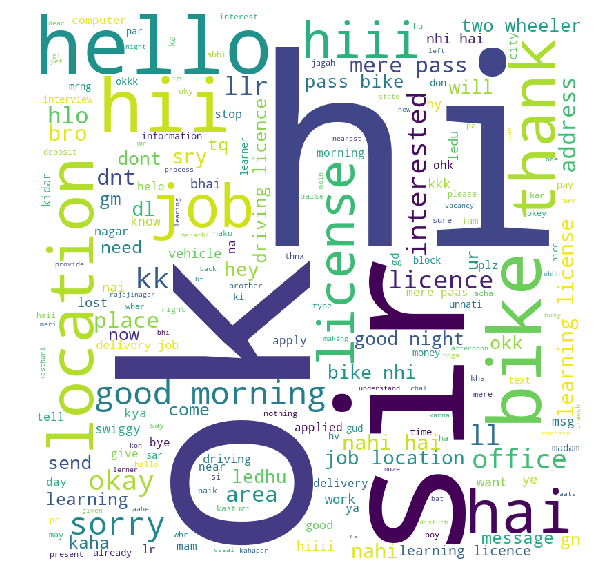

In [17]:
for val in df2.message: 

    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## Frequency table for individual words in messages of our dataset

In [18]:
from collections import defaultdict

In [19]:
counter = defaultdict(lambda : 0)

def wordCounter(message):
    message = message.split()
    for word in message:
        counter[word] += 1
    
df2['message'].apply(wordCounter)
wordCounts = pd.DataFrame()
wordCounts['Word'] = counter.keys()
wordCounts['Frequency'] = counter.values()

wordCounts.sort_values(['Frequency', 'Word'], ascending=False, inplace=True)
wordCounts

,Word,Frequency
20,Ok,268
4,Hi,268
12,I,185
14,have,138
5,Hello,91
98,bike,90
10,Hii,78
6,sir,72
35,No,48
3,hi,47
